In [30]:
import nbimporter
import pandas as pd
import names
import numpy as np
from sklearn import datasets
from collections import defaultdict
from scipy.stats import truncnorm
# import matplotlib.pyplot as plt
import random
import stats_employees_m1
import numpy as np
import pandas as pd

from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid

# We now are moving into features that will correlate but not through a correlation matrix but rather
# through far more manual methods.
import heapq
import math
import random

import names

import matplotlib.pyplot as plt
# %matplotlib inline

In [31]:
def discretize(vector, range):
    newRange = range
    vals = [range]
    x = True
    while(x):
        range -= 1
        if abs(range) <= newRange:
            vals.append(range)
        else:
            x=False
    roundedVals = []
    for x in vector:
        newVal = int(x)
        if abs(newVal) > newRange:
            # if greater than the newRange:
            if newVal < 0:
                newVal = -1*newRange
            else:
                newVal = 1*newRange
        roundedVals.append(newVal)
    return roundedVals

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# Replaces all neg values with zero
def negsToZero(array):
    adjustedArray = array
    for x in range(len(adjustedArray)):
        if adjustedArray[x] < 0:
            adjustedArray[x] = 0
    return adjustedArray

# Replaces all negative values with their abs value
def negsToOpp(array):
    adjustedArray = array
    for x in range(len(adjustedArray)):
        if adjustedArray[x] < 0:
            adjustedArray[x] = -1 * adjustedArray[x]
    return adjustedArray

# Replaces all values under the mini values w/ mini and all values above the maxi value w/ maxi
def imposeBoundaries(array, mini, maxi):
    adjustedArray = array
    for x in range(len(adjustedArray)):
        if adjustedArray[x] < mini:
            adjustedArray[x] = mini
        if adjustedArray[x] > maxi:
            adjustedArray[x] = maxi
    return adjustedArray
def generateFields(probs, labels, ppl):
    fields = []
    for x in range(len(probs)):
        fields += [labels[x] for y in range(int(ppl*probs[x]))]
    return fields

# Education Stuff Generated ... 
def genEducation(numPpl, jobPerf):
    leftover = []
    one_half = math.floor(numPpl * .5)
    top = heapq.nlargest(one_half, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top)
    education = np.zeros(numPpl)

    tophalf_labels = generateFields([.3, .67, .03], [2, 1, 0], len(top))
    random.shuffle(tophalf_labels)
    
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    for x in top:
        education[x] = tophalf_labels.pop()
    
    bottomhalf_labels = generateFields([.1, .83, .07], [2, 1, 0], len(leftover))
#     print(len(bottomhalf_labels))
#     print(len(leftover))
    random.shuffle(bottomhalf_labels)
    
    for x in leftover:
        education[x] = bottomhalf_labels.pop()
    return education

def genEducationalPrestige(numPpl, jobPerf, education):
    leftover = []
    one_third = math.floor(numPpl * .33)
    top_third = heapq.nlargest(one_third, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top_third)
    
    educationalPrestige = np.zeros(numPpl)
    topthird_labels = generateFields([.45, .45, .1], [3, 2, 1], len(top_third))
    random.shuffle(topthird_labels)

    for x in range(len(jobPerf)):
        if x not in top_third:
            leftover.append(x)
    for x in top:
        if education[x] == 0:
            educationalPrestige[x] = 0
        else:
            educationalPrestige[x] = topthird_labels.pop()
    
    second_third = heapq.nlargest(one_third, range(len(leftover)), leftover.__getitem__)
    random.shuffle(second_third)
    secondthird_labels = generateFields([.2, .6, .2], [3, 2, 1], len(second_third))
    random.shuffle(secondthird_labels)

    last = []
    for x in range(len(leftover)):
        if x not in second_third:
            last.append(x)
    for x in second_third:
        if education[x] == 0:
            educationalPrestige[x] = 0
        else:
            educationalPrestige[x] = secondthird_labels.pop()
    
    lastthird_labels = generateFields([.05, .15, .8], [3, 2, 1], len(last))
    random.shuffle(lastthird_labels)
    
    for x in last:
        if education[x] == 0:
            educationalPrestige[x] = 0
        else:
            educationalPrestige[x] = lastthird_labels.pop()
    return educationalPrestige

def genDegreeTypes(numPpl, jobPerf, education, skew):
    labels = ["Humanities", "Sciences", "Quantitative", "Engineering"]
    degree = []
    fields = []
    if skew == "standard":
        standardProbs = [.25, .25, .25, .25]
        standardFields = generateFields(degreeProbs, labels, numPpl)
        for x in range(len(jobPerf)):
            if education[x] == 0:
                degree.append("None")
            else:
                degree.append(random.choice(standardFields))
    elif skew == "biased": 
        poorPerf = generateFields([.5, .3, .1, .1], labels, numPpl)
        goodPerf = generateFields([.1, .1, .3, .5], labels, numPpl)
        for x in range(len(jobPerf)):
            if education[x] == 0:
                degree.append("None")
            else:
                if jobPerf[x] == -2 or jobPerf[x] == -1 or jobPerf[x] == 0: 
                    degree.append(random.choice(poorPerf))
                else:
                    degree.append(random.choice(goodPerf))
    return degree  
    
def genLinkedinScore(numPpl, jobPerf):
    # Percentage of students with low-tier - (0), mid-tier(1), high tier university(2)
    labels = ['None', 'Ok', "Very Good"]
    worst = generateFields([.4, .40, .10], labels, numPpl)
    med = generateFields([.20, .50, .30], labels, numPpl)
    high = generateFields([.10, .40, .50], labels, numPpl)
    linkedinScore = []
    
    for x in range(len(jobPerf)):
        if jobPerf[x] < 0:
            linkedinScore.append(random.choice(worst))
        if jobPerf[x] > 0 and jobPerf[x] < 2:
            linkedinScore.append(random.choice(med))
        if jobPerf[x] > 2:
            linkedinScore.append(random.choice(high))
    return linkedinScore


def responsibleSocMediaUse(numPpl, jobPerf):
    # Percentage of students with low-tier - (0), mid-tier(1), high tier university(2)
    labels = ["Bad", "Good"]
    worst = generateFields([.5, .5], labels, numPpl)
    med = generateFields([.2, .8], labels, numPpl)
    high = generateFields([.05, .95], labels, numPpl)
    socialmediaScore = []
    
    for x in range(len(jobPerf)):
        if jobPerf[x] < 0:
            socialmediaScore.append(random.choice(worst))
        if jobPerf[x] > 0 and jobPerf[x] < 2:
            socialmediaScore.append(random.choice(med))
        if jobPerf[x] > 2:
            socialmediaScore.append(random.choice(high))
    return socialmediaScore

def genArrestRecords(numPpl, jobPerf):
    one_fifth = math.floor(numPpl * .8)
    top = heapq.nlargest(one_fifth, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top)
    leftover = []
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    arrestRecords = np.zeros(numPpl)
    for x in range(math.floor(numPpl * .2)):
        if x < math.floor(numPpl * .2) * .6:
            arrestRecords[leftover[x]] = 1
        else: 
            arrestRecords[top[x]] = 1
    return arrestRecords

def genCriminalRecords(numPpl, jobPerf):
    one_tenth = math.floor(numPpl * .9)
    top = heapq.nlargest(one_tenth, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top)
    leftover = []
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    criminalRecords = np.zeros(numPpl)
    print(criminalRecords.shape)
    for x in range(math.floor(numPpl * .1)):
        if x < math.floor(numPpl * .1) * .75:
            criminalRecords[leftover[x]] = 1
        else: 
            criminalRecords[top[x]] = 1
    return criminalRecords

# Manual Generation of features w/ job Performance...
def genEmployeeReferrals(numPpl, top, leftover, cutoff, numOfReferrals):
    indxs = top
    np.random.shuffle(indxs)
    np.random.shuffle(leftover)
    
    numOfTop = math.floor(len(indxs) * cutoff)
#     print(numOfTop)
    array = np.zeros(numPpl)
#     print(numOfReferrals)
    for x in range(numOfReferrals):
        if x < numOfTop:
            array[top[x]] = 1
        elif x >= numOfTop: 
            array[leftover[x]] = 1
    return array

def genHireVueScores(numPpl, jobPerf):
    leftover = []
    one_third = math.floor(numPpl * .33)
    top = heapq.nlargest(one_third, range(len(jobPerf)), jobPerf.__getitem__)
    hirevueScores = np.zeros(numPpl)
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    for x in top:
        hirevueScores[x] = 2
            
    last = []
    second = heapq.nlargest(one_third, range(len(leftover)), leftover.__getitem__)
    for x in range(len(leftover)):
        if x not in second:
            last.append(x)
    for x in second:
        hirevueScores[x] = 1
    
    # Now we "inject" randomness
    percentileOfRandomness = .1
    np.random.shuffle(top)
    np.random.shuffle(second)
    np.random.shuffle(last)
    
    for x in range(math.floor(one_third*percentileOfRandomness)):
        scores = [0, 1, 2]
        hirevueScores[top[x]] = random.choice(scores)
        hirevueScores[second[x]] = random.choice(scores)
        hirevueScores[last[x]] = random.choice(scores)
    return hirevueScores


def genSportScores(numPpl, jobPerf):
    leftover = []
    one_third = math.floor(numPpl * .33)
    top = heapq.nlargest(one_third, range(len(jobPerf)), jobPerf.__getitem__)
    scores = np.zeros(numPpl)
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    for x in top:
        scores[x] = 2
            
    last = []
    second = heapq.nlargest(one_third, range(len(leftover)), leftover.__getitem__)
    for x in range(len(leftover)):
        if x not in second:
            last.append(x)
    for x in second:
        scores[x] = 1
    
    # Now we "inject" randomness
    percentileOfRandomness = .1
    np.random.shuffle(top)
    np.random.shuffle(second)
    np.random.shuffle(last)
    
    for x in range(math.floor(one_third*percentileOfRandomness)):
        labels = [0, 1, 2]
        scores[top[x]] = random.choice(labels)
        scores[second[x]] = random.choice(labels)
        scores[last[x]] = random.choice(labels)
    return scores


def genCulturalFit(numPpl, jobPerf):
    leftover = []
    one_fourth = math.floor(numPpl * .25)
    top = heapq.nlargest(one_fourth, range(len(jobPerf)), jobPerf.__getitem__)
    random.shuffle(top)
    culturalFitScores = np.zeros(numPpl)
    for x in range(len(jobPerf)):
        if x not in top:
            leftover.append(x)
    for x in top:
        culturalFitScores[x] = 2 
            
    last = []
    second = heapq.nlargest(one_fourth, range(len(leftover)), leftover.__getitem__)
    random.shuffle(second)
    for x in range(len(leftover)):
        if x not in second:
            last.append(x)
    for x in second:
        culturalFitScores[x] = 1
    
    # Now we "inject" randomness
    percentileOfRandomness = .25
    np.random.shuffle(top)
    np.random.shuffle(second)
    np.random.shuffle(last)
    
    for x in range(math.floor(one_fourth*percentileOfRandomness)):
        scores = [0, 1, 2]
        culturalFitScores[top[x]] = random.choice(scores)
        culturalFitScores[second[x]] = random.choice(scores)
        culturalFitScores[last[x]] = random.choice(scores)
    return culturalFitScores

# Birth Origin
def genBirthOrigin(numPpl, countries, countryProbs):
    array = []
    for x in range(len(countryProbs)):
        subarray = [countries[x] for y in range(int(countryProbs[x]*numPpl))]
        array += subarray
    candidateCountries = [random.choice(array) for y in range(numPpl)]
    return candidateCountries

def genAge(numPpl):
    ages = get_truncated_normal(mean=23, sd=3, low=19, upp=50)
    return np.rint(ages.rvs(numPpl))
    
    
def binaryArrayGenerator(n, p): #where n is num values and p is the probability of success (1)
    x = np.zeros(n)
    num = int(p*100)
    x[:num] = 1
    np.random.shuffle(x)
    return x

def getTopIndxs(array, num):
    leftover = []
    top = heapq.nlargest(num, range(len(array)), array.__getitem__)
    for x in range(len(array)):
        if x not in top:
            leftover.append(x)
    return top, leftover   


In [32]:
def featuresCorrelatingToMetric(numPpl, matrix, numVars=0):
    m = np.array(matrix)
    res = np.matmul(m, m.T)
    method = cholesky
    r = res
    print(res)
    # Generate samples from three independent normally distributed random
    # variables (with mean 0 and std. dev. 1).
    x = norm.rvs(size=(numVars, numPpl))
    print(np.linalg.eigvals(r))

    # We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
    # the Cholesky decomposition, or the we can construct `c` from the
    # eigenvectors and eigenvalues.

    if method == 'cholesky':
        # Compute the Cholesky decomposition.
        c = cholesky(r, lower=True)
    else:
        # Compute the eigenvalues and eigenvectors.
        evals, evecs = eigh(r)
        # Construct c, so c*c^T = r.
        c = np.dot(evecs, np.diag(np.sqrt(evals)))
    # Convert the data to correlated random variables. 
    y = np.dot(c, x)
    # y[0] is the job performance, and we want to bucket y-vals from -2 to +2
    return y[0], y[1:]


# Correlates for Metric1 - Job Performance

In [33]:
# Transform features, takes the raw correlated features and fits them into a proper range and bounds.
def transformFeatures(correlatedFeatures):
    education = np.round(correlatedFeatures[0] * .3, 2)
    gpa = np.round(correlatedFeatures[1] * .2 + 3, 2) # GPA
    # techApt = imposeBoundaries(y[3] / 3 + 2, 0, 4) # Technical Aptitude
    educationalPrestige = np.round(correlatedFeatures[2] / 3 + 2, 1)
    # softSkills = imposeBoundaries(y[4] / 3 + 3, 0, 5) # Soft Skills
    softSkills = np.round(correlatedFeatures[3] / 3 + 3, 2)
    # yearsOfExperience = negsToZero(y[5] + 4) # Years of Experience
    yearsOfExperience = np.round(correlatedFeatures[4] + 4, 1)
    return education, gpa, educationalPrestige, softSkills, yearsOfExperience

In [34]:
employeeData = pd.DataFrame()
gender = "female"
race = "Asian"
numPpl = stats_employees_m1.loadPpl(race, gender)
numPpl

120

[[10.0021    6.23373   4.19849   3.2561    7.26461   5.2858  ]
 [ 6.23373   6.346149  1.377637  1.75      3.291293  3.996   ]
 [ 4.19849   1.377637  5.906381  1.2386    3.992109  1.9011  ]
 [ 3.2561    1.75      1.2386    6.672401  2.99991   0.35139 ]
 [ 7.26461   3.291293  3.992109  2.99991   6.266301  4.33896 ]
 [ 5.2858    3.996     1.9011    0.35139   4.33896   6.597104]]
[2.61133594e+01 3.47938463e-03 1.44985390e+00 2.53764659e+00
 5.14437724e+00 6.54171944e+00]


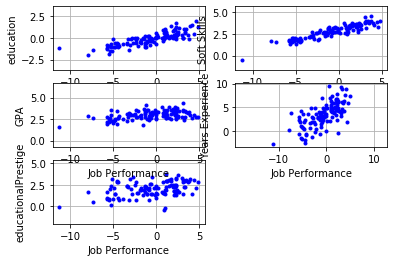

In [35]:
# featuresCorrelatingToMetric generates the "Job Performance" feature along with all
# other features we desire to correlate with "Job Performance" is systematized way
# the method uses the cholesky decomposition of a covariance matrix to generate a 
# correlation matrix which is multiplied against the set number of features to correlate with job
# performance that are initially random normal distributions with stddev = 1 and mean = 0


matrix = [
         [1.3, .1, -1.1, 1.5, 1.5, 1.61],
         [1.0, -1., .3, 1.5, 1.01, .993],
         [1.1, .8, -1.1, 1.01, -1, .909],
         [1.1, 0.2, -1.001, 1.1, .98, -1.5],
         [1.05, 1.02, -1.01, 1.02, 1.03, 1.001],
         [1.03 , .998, 1.01,.9, 1.01, 1.3],
         ]
jobPerf, correlatedFeatures = featuresCorrelatingToMetric(numPpl, matrix, numVars=6)
education, gpa, educationalPrestige, softSkills, yearsOfExp = transformFeatures(correlatedFeatures)
# Plot various projections of the samples.
subplot(3,2,5)
plot(jobPerf, educationalPrestige, 'b.')
xlabel("Job Performance")
ylabel("educationalPrestige")
axis('equal')
grid(True)

subplot(3,2,1)
plot(jobPerf, education, 'b.')
ylabel('education')
axis('equal')
grid(True)

subplot(3,2,2) 
plot(jobPerf, softSkills, 'b.')
ylabel("Soft Skills")
axis('equal')
grid(True)

subplot(3,2,3)
plot(jobPerf, gpa, 'b.')
xlabel('Job Performance')
ylabel('GPA')
axis('equal')
grid(True)

subplot(3,2,4)
plot(jobPerf, yearsOfExp, 'b.')
xlabel('Job Performance')
ylabel('Years Experience')
axis('equal')
grid(True)

show()

In [36]:
employeeData["Education"] = education
employeeData["GPA"] = gpa
employeeData["Educational Prestige"] = educationalPrestige
employeeData["Years of Experience"] = yearsOfExp
employeeData["Soft Skills"] = softSkills
employeeData["Manager's Assessment Score"] = np.round(jobPerf, 2)


# Generating Correlates for Metric2 - Job Tenure

In [37]:
def transformTenureCorrelates(jobTenure, correlatesToTenure):
    jobTenure = np.round(negsToZero(jobTenure + 3), 1)
    militaryTenure = np.round(negsToZero(correlatesToTenure[0] * .5 + 2), 1) # militaryTenure
    commuteTime = np.round(negsToOpp(correlatesToTenure[1] * 10 + 30), 0)# commuteTime
    culturalFit = np.round(correlatesToTenure[2], 2)
    return jobTenure, militaryTenure, commuteTime, culturalFit

[[ 4.86  4.96 -2.72  4.19]
 [ 4.96  5.19 -2.29  4.28]
 [-2.72 -2.29  7.09 -1.97]
 [ 4.19  4.28 -1.97  3.66]]
[1.55382437e+01 5.17440585e+00 4.36191993e-03 8.29885059e-02]


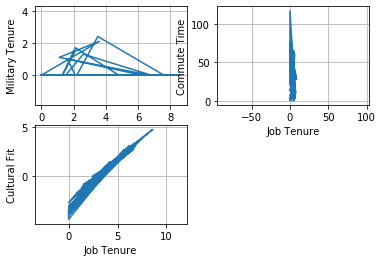

In [38]:
matrix = [
        [  1.20, 1.00, 1.10, 1.10],
        [ 1.00,  .90, 1.30, 1.3],
        [ -1.20,  -1.50,  -1.20, 1.4],
        [1.00, .9, .8, 1.1]
    ]

jobTenure, correlatesToTenure = featuresCorrelatingToMetric(numPpl, matrix , numVars=4)
# print(len(jobTenure))
jobTenure, militaryTenure, commuteTime, culturalFit = transformTenureCorrelates(jobTenure, correlatesToTenure)

# Need to make it such that most military time = 0.
for x in range(len(militaryTenure)):
    if np.random.uniform(0, 1) < .9:
        militaryTenure[x] = 0
        
employeeData["Military Tenure"] = militaryTenure
employeeData["Avg Commute Time"] = commuteTime
employeeData["Job Tenure"] = jobTenure
employeeData["Cultural Fit"] = culturalFit


subplot(2, 2, 1)
plot(jobTenure, militaryTenure)
xlabel('Job Tenure')
ylabel('Military Tenure')
axis('equal')
grid(True)


subplot(2, 2, 2)
plot(jobTenure, commuteTime)
xlabel('Job Tenure')
ylabel('Commute Time')
axis('equal')
grid(True)

subplot(2, 2, 3)
plot(jobTenure, culturalFit)
xlabel('Job Tenure')
ylabel('Cultural Fit')
axis('equal')
grid(True)

show()

# Generating Correlates for Metric3 - Deals Closed


In [39]:
#  Insert another metric # 
matrix_dealsClosed = [
    [1.3, .1, 1.1, 1.5],
    [1.0, 1., .3, 1.5],
    [1.1, .8, 1.1, 1.01],
    [1.1, 0.2, 1.001, 1.1],
]
dealsClosed, correlatesToDealsClosed = featuresCorrelatingToMetric(numPpl, matrix_dealsClosed , numVars=4)

[[5.16     3.98     4.235    4.2011  ]
 [3.98     4.34     3.745    3.2503  ]
 [4.235    3.745    4.0801   3.5821  ]
 [4.2011   3.2503   3.5821   3.462001]]
[1.58390244e+01 9.07804471e-01 9.50316454e-04 2.94321773e-01]


[ 4.86  7.9   8.18  8.03  5.28  8.95  9.36  7.59  5.82  6.79  7.89  8.3
 10.37  7.4   7.73  7.02  7.36  5.72  8.    3.74  8.96  9.26  4.75  3.84
  7.5   8.13 10.33  7.5   7.54  7.65  6.25  4.    5.12  3.8  10.93  5.41
 11.64 12.61  3.2   6.36  9.03  6.17  8.29  8.94  6.08  5.23  6.54  6.6
  9.36  5.43  7.    7.71  9.32  8.51  7.4  11.5   5.51  5.17  1.87  7.71
  3.61  6.85  6.05 10.38  9.13 10.22  4.74  0.65  4.11  9.23  7.37  4.29
  6.89  1.48  6.36  5.78  8.4   7.58  9.05  9.64  8.45  6.85  4.29  6.33
 13.08  7.    5.43  6.75  3.59  9.27  5.8   6.91  7.58  8.36  2.47  3.77
 10.71  4.57  9.    6.54  5.66  5.52  6.8  11.43  7.52  3.43 10.05  9.52
  4.28  6.31  8.8   7.19  4.89  9.41  5.32  6.5  10.27  5.52  5.85  6.04]


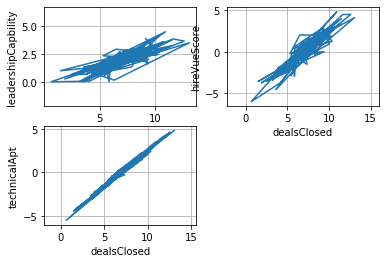

In [40]:
def transformDealCorrelates(dealsClosed, correlatesToDeals):
    dealsClosed = np.round(negsToZero(dealsClosed + 7), 2)
    leadershipCapability = np.round(negsToZero(correlatesToDeals[0] * .5 + 2), 2) # leadership
    hirevueScore = np.round(correlatesToDeals[1], 2) # hireVue
    technicalApt = np.round(correlatesToDeals[2], 2) # technical aptitude
    return dealsClosed, leadershipCapability, hirevueScore, technicalApt


dealsClosed, leadershipCapability, hirevueScore, technicalApt = transformDealCorrelates(dealsClosed, correlatesToDealsClosed)

# bottom60percentile = np.percentile(leadershipCapability, 60)
# bottom60thvalues = [leadershipCapability[x] for x in range(len(leadershipCapability)) if leadershipCapability[x] < bottom60percentile]
# skewed_leadershipCapability = [leadershipCapability[x] if leadershipCapability[x] < bottom60percentile else random.choice(bottom60thvalues) for x in range(len(leadershipCapability))]

employeeData["Leadership Capability"] = leadershipCapability
employeeData["HireVue Score"] = hirevueScore
employeeData["Technical Aptitude"] = technicalApt
employeeData["Avg Deals Closed"] = dealsClosed


subplot(2, 2, 1)
plot(dealsClosed, leadershipCapability)
xlabel('dealsClosed')
ylabel('leadershipCapbility')
axis('equal')
grid(True)


subplot(2, 2, 2)
plot(dealsClosed, hirevueScore)
xlabel('dealsClosed')
ylabel('hireVueScore')
axis('equal')
grid(True)

subplot(2, 2, 3)
plot(dealsClosed, technicalApt)
xlabel('dealsClosed')
ylabel('technicalApt')
axis('equal')
grid(True)

print(dealsClosed)

In [41]:
percentileToNum = math.floor(.20 * numPpl)
numOfReferrals = math.floor(.25 * numPpl)
top, leftover = getTopIndxs(jobPerf, percentileToNum)

employeeReferrals = genEmployeeReferrals(numPpl, top, leftover, .85, numOfReferrals) 
# hirevueScores = genHireVueScores(numPpl, jobPerf)
# culturalFit = genCulturalFit(numPpl, jobPerf)
# education = genEducation(numPpl, jobPerf)
degrees = genDegreeTypes(numPpl, jobPerf, education, "biased")   
linkedinScore = genLinkedinScore(numPpl, jobPerf)
socialmediaScore = responsibleSocMediaUse(numPpl, jobPerf)
# educationalPrestige = genEducationalPrestige(numPpl, jobPerf, education)  
arrestRecords = genArrestRecords(numPpl, jobPerf)
criminalRecords = genCriminalRecords(numPpl, jobPerf)


# employeeData["Education"] = education
# employeeData["Educational Prestige"] = educationalPrestige
employeeData["Undergraduate Degree"] = degrees
employeeData["LinkedIn Score"] = linkedinScore
employeeData["Responsible Social Media Use"] =  socialmediaScore
employeeData["Employee Referral"] = employeeReferrals
# employeeData["HireVue Score"] = hirevueScores
employeeData["Arrest Record"] = arrestRecords
employeeData["Criminal Record"] = criminalRecords
employeeData["Names"] = [names.get_full_name(gender = gender) for x in range(numPpl)]
employeeData["Race"] = [race for x in range(numPpl)]
employeeData["Gender"] = [gender for x in range(numPpl)] 
employeeData["Sports"] = genSportScores(numPpl, jobPerf)

employeeData["Birth Origin"] = genBirthOrigin(numPpl, ["USA", "China", "Australia", "Canada"], [.80, .10, .05, .05])

ages = genAge(numPpl)

for x in range(len(ages)):
    ages[x] += int(yearsOfExp[x]) + int(militaryTenure[x]) + int(jobTenure[x])
print(ages)
employeeData["Age"] = ages
# employeeData["Cultural Fit"] = culturalFit

(120,)
[28. 25. 27. 34. 28. 28. 22. 24. 26. 24. 28. 27. 37. 35. 26. 32. 34. 23.
 30. 31. 38. 31. 23. 29. 30. 30. 31. 30. 29. 28. 34. 29. 34. 35. 29. 26.
 38. 21. 25. 27. 31. 31. 31. 28. 36. 32. 29. 28. 27. 31. 28. 25. 24. 30.
 32. 24. 29. 27. 30. 29. 32. 24. 33. 27. 39. 36. 33. 32. 29. 39. 36. 25.
 29. 33. 27. 29. 36. 26. 27. 34. 29. 25. 29. 29. 25. 26. 24. 31. 28. 32.
 29. 33. 28. 22. 27. 37. 30. 27. 31. 33. 25. 23. 27. 26. 31. 37. 21. 30.
 31. 31. 30. 39. 26. 24. 31. 31. 30. 28. 25. 32.]


In [42]:
# Cell for generating disparate commute times... 
bayArea = pd.read_csv("bayArea.csv")
print(bayArea.info())

def genZips(dataset):
    df = dataset.copy()
    commuteTimes = df["Avg Commute Time"]
    zips = []
    for x in range(len(df)):
        index = np.argmin(np.abs(np.asarray(bayArea["Avg Commute Times"]) - np.asarray(commuteTimes[x])))
        zipCode = bayArea.iloc[index]["ZIP"]
        zips.append(zipCode)
    df["ZIP"] = zips
    return zips

zips = genZips(employeeData)
employeeData["Zip"] = zips

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         187 non-null    int64  
 1   PO_NAME            187 non-null    object 
 2   the_geom           187 non-null    object 
 3   ZIP                187 non-null    int64  
 4   STATE              187 non-null    object 
 5   Area__             187 non-null    float64
 6   Length__           187 non-null    float64
 7   Avg Commute Times  187 non-null    float64
 8   Latitude           187 non-null    float64
 9   Longitude          187 non-null    float64
dtypes: float64(5), int64(2), object(3)
memory usage: 14.7+ KB
None


In [43]:
# We now want to sanity check our manipulations and analysis by hand if the relations we desire are holding
print(employeeData.groupby(['Employee Referral', "Manager's Assessment Score"]).size())
print(employeeData.groupby(['Cultural Fit', "Manager's Assessment Score"]).size())
print(employeeData.groupby(['HireVue Score', "Manager's Assessment Score"]).size())

Employee Referral  Manager's Assessment Score
0.0                -7.87                         1
                   -7.34                         1
                   -5.75                         1
                   -5.72                         1
                   -5.66                         1
                                                ..
1.0                 3.96                         1
                    4.15                         1
                    4.39                         1
                    4.59                         1
                    4.84                         1
Length: 115, dtype: int64
Cultural Fit  Manager's Assessment Score
-4.43          2.32                         1
-4.08          3.76                         1
-4.03         -5.72                         1
-3.89          3.46                         1
-3.80         -2.27                         1
                                           ..
 3.29         -2.85                         1
 3.3

In [44]:
employeeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Education                     120 non-null    float64
 1   GPA                           120 non-null    float64
 2   Educational Prestige          120 non-null    float64
 3   Years of Experience           120 non-null    float64
 4   Soft Skills                   120 non-null    float64
 5   Manager's Assessment Score    120 non-null    float64
 6   Military Tenure               120 non-null    float64
 7   Avg Commute Time              120 non-null    float64
 8   Job Tenure                    120 non-null    float64
 9   Cultural Fit                  120 non-null    float64
 10  Leadership Capability         120 non-null    float64
 11  HireVue Score                 120 non-null    float64
 12  Technical Aptitude            120 non-null    float64
 13  Avg D

In [45]:
employeeData.to_csv("employeeData_" + gender + "_" + race + ".csv")